In [1]:
import asyncio
import time
import logging

import vector; vector.register_awkward()

import awkward as ak
import cabinetry
from coffea import processor
from coffea.processor import servicex
from coffea.nanoevents import transforms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from func_adl import ObjectStream
import hist
import json
import matplotlib.pyplot as plt
import numpy as np
import uproot

import utils  # contains code for bookkeeping and cosmetics, as well as some boilerplate

logging.getLogger("cabinetry").setLevel(logging.INFO)

In [2]:
### GLOBAL CONFIGURATION

# input files per process, set to e.g. 10 (smaller number = faster)
N_FILES_MAX_PER_SAMPLE = 10

# pipeline to use:
# - "coffea" for pure coffea setup
# - "servicex_processor" for coffea with ServiceX processor
# - "servicex_databinder" for downloading query output and subsequent standalone coffea
PIPELINE = "coffea"

# enable Dask (may not work yet in combination with ServiceX outside of coffea-casa)
USE_DASK = True

# ServiceX behavior: ignore cache with repeated queries
SERVICEX_IGNORE_CACHE = True

# analysis facility: set to "coffea_casa" for coffea-casa environments, "EAF" for FNAL, "local" for local setups
AF = "coffea_casa"

In [3]:
fileset = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, use_xcache=False)

In [4]:
fileset.keys()

dict_keys(['ttbar__nominal', 'ttbar__scaledown', 'ttbar__scaleup', 'ttbar__ME_var', 'ttbar__PS_var', 'single_top_s_chan__nominal', 'single_top_t_chan__nominal', 'single_top_tW__nominal', 'wjets__nominal'])

In [5]:
fileset['ttbar__nominal'].keys()

dict_keys(['files', 'metadata'])

In [6]:
fileset['ttbar__nominal']['files']

['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root',
 'https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/020D0AF1-4BC2-E511-BDFC-0026B95ADB18.root',
 'https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/02837459-03C2-E511-8EA2-002590A887AC.root',
 'https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0400D1B1-4CC2-E511-AD14-AC853DA06A1A.root',
 'https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15

In [7]:
fileset['wjets__nominal']['files']

['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/002B75B9-10DB-E511-915B-02163E017888.root',
 'https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/006E9C0C-12DB-E511-981C-00261894397D.root',
 'https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/0097C77B-12DB-E511-AAC0-02163E011796.root',
 'https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00B697CF-10DB-E511-A9D9-782BCB407CFD.root',
 'https://xrootd-loc

In [8]:
file_sig = uproot.open(fileset['ttbar__nominal']['files'][0])
events_tree_sig = file_sig['events']
events_sig = events_tree_sig.arrays(["electron_pt",
                                    "muon_pt",
                                    "jet_pt",
                                    "jet_eta",
                                    "jet_phi",
                                    "jet_mass",
                                    "jet_btag"],entry_stop=1000)

file_bkg = uproot.open(fileset['wjets__nominal']['files'][0])
events_tree_bkg = file_bkg['events']
events_bkg = events_tree_bkg.arrays(["electron_pt",
                                     "muon_pt",
                                     "jet_pt",
                                     "jet_eta",
                                     "jet_phi",
                                     "jet_mass",
                                     "jet_btag"])

In [9]:
len(events_bkg)

38412

In [10]:
selected_electrons_pt_sig = events_sig.electron_pt[events_sig.electron_pt > 25]
selected_muons_pt_sig = events_sig.muon_pt[events_sig.muon_pt > 25]
selected_jet_pt_sig = events_sig.jet_pt[events_sig.jet_pt > 25]
selected_jet_btag_sig = events_sig.jet_btag[events_sig.jet_pt > 25]

selected_electrons_pt_bkg = events_bkg.electron_pt[events_bkg.electron_pt > 25]
selected_muons_pt_bkg = events_bkg.muon_pt[events_bkg.muon_pt > 25]
selected_jet_pt_bkg = events_bkg.jet_pt[events_bkg.jet_pt > 25]
selected_jet_btag_bkg = events_bkg.jet_btag[events_bkg.jet_pt > 25]

In [11]:
B_TAG_THRESHOLD = 0.5

event_filters = ((ak.count(selected_electrons_pt_sig, axis=1) + ak.count(selected_muons_pt_sig, axis=1)) == 1)
event_filters = event_filters & (ak.count(selected_jet_pt_sig, axis=1) >= 4)
event_filters = event_filters & (ak.sum(selected_jet_btag_sig >= B_TAG_THRESHOLD, axis=1) >= 1) # one b-tagged jet

selected_events_sig = events_sig[event_filters]
selected_electrons_pt_sig = selected_electrons_pt_sig[event_filters]
selected_muons_pt_sig = selected_muons_pt_sig[event_filters]
selected_jet_pt_sig = selected_jet_pt_sig[event_filters]
selected_jet_btag_sig = selected_jet_btag_sig[event_filters]


event_filters = ((ak.count(selected_electrons_pt_bkg, axis=1) + ak.count(selected_muons_pt_bkg, axis=1)) == 1)
event_filters = event_filters & (ak.count(selected_jet_pt_bkg, axis=1) >= 4)
event_filters = event_filters & (ak.sum(selected_jet_btag_bkg >= B_TAG_THRESHOLD, axis=1) >= 1)

selected_events_bkg = events_bkg[event_filters]
selected_electrons_pt_bkg = selected_electrons_pt_bkg[event_filters]
selected_muons_pt_bkg = selected_muons_pt_bkg[event_filters]
selected_jet_pt_bkg = selected_jet_pt_bkg[event_filters]
selected_jet_btag_bkg = selected_jet_btag_bkg[event_filters]

In [12]:
selected_lepton_pt_sig = ak.sum(selected_electrons_pt_sig,axis=-1) + ak.sum(selected_muons_pt_sig,axis=-1)
selected_lepton_pt_bkg = ak.sum(selected_electrons_pt_bkg,axis=-1) + ak.sum(selected_muons_pt_bkg,axis=-1)

In [13]:
selected_jet_ht_sig = ak.sum(selected_jet_pt_sig, axis=-1)
selected_jet_ht_bkg = ak.sum(selected_jet_pt_bkg, axis=-1)

In [14]:
selected_jet_pt0_sig = ak.max(selected_jet_pt_sig, axis=-1)
selected_jet_pt0_bkg = ak.max(selected_jet_pt_bkg, axis=-1)

In [15]:
sigbkghist = hist.Hist(
    hist.axis.Regular(50, 0, 2000, name="HT", label="$H_T$"),
    hist.axis.Regular(50, 0, 300, name="leptonpt", label="$p_T^{\mu,e}$"),
    hist.axis.Regular(50, 0, 300, name="ljpt", label="Leading Jet $p_T$"),
    hist.axis.StrCategory(["sig", "bkg"], name="category", label="Category"),
)

In [16]:
sigbkghist.fill(HT = selected_jet_ht_sig, 
                leptonpt = selected_lepton_pt_sig, 
                ljpt = selected_jet_pt0_sig, 
                category = "sig")
sigbkghist.fill(HT = selected_jet_ht_bkg, 
                leptonpt = selected_lepton_pt_bkg, 
                ljpt = selected_jet_pt0_bkg, 
                category = "bkg")

Hist(
  Regular(50, 0, 2000, name='HT', label='$H_T$'),
  Regular(50, 0, 300, name='leptonpt', label='$p_T^{\\mu,e}$'),
  Regular(50, 0, 300, name='ljpt', label='Leading Jet $p_T$'),
  StrCategory(['sig', 'bkg'], name='category', label='Category'),
  storage=Double()) # Sum: 502.0 (512.0 with flow)

In [17]:
print("Num Signal = ", len(selected_jet_ht_sig))
print("Num Background = ", len(selected_jet_ht_bkg))

Num Signal =  302
Num Background =  210


In [18]:
sigbkghist.axes

(Regular(50, 0, 2000, name='HT', label='$H_T$'),
 Regular(50, 0, 300, name='leptonpt', label='$p_T^{\\mu,e}$'),
 Regular(50, 0, 300, name='ljpt', label='Leading Jet $p_T$'),
 StrCategory(['sig', 'bkg'], name='category', label='Category'))

In [19]:
s = sigbkghist.stack("category")

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f040c96a400>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f040c9a7100>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

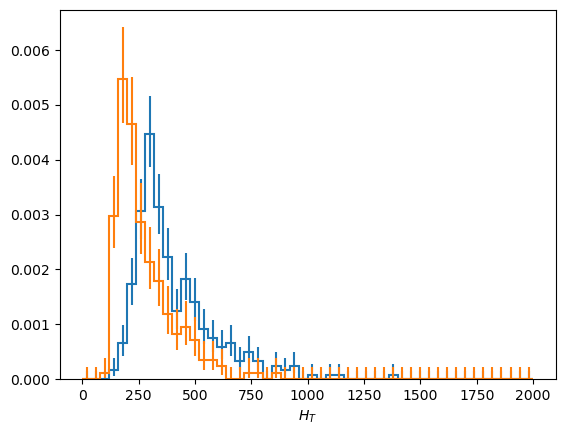

In [20]:
s.project("HT").plot(density=True)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f040af25fa0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f040af42b50>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

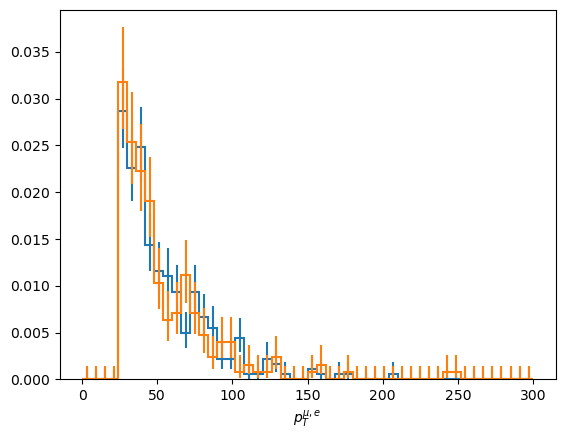

In [21]:
s.project("leptonpt").plot(density=True)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f040b30a700>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f040b3f0310>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

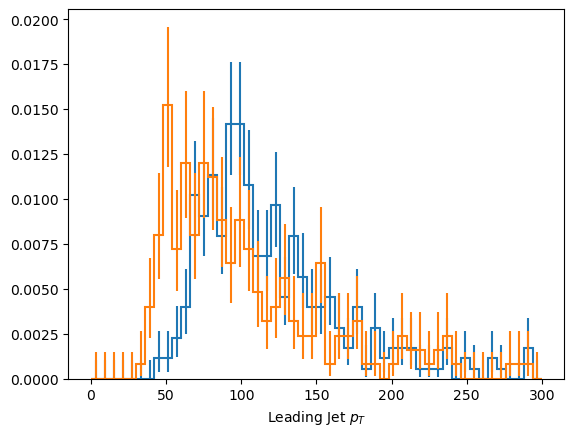

In [22]:
s.project("ljpt").plot(density=True)

In [23]:
selected_jet_ht = ak.concatenate([selected_jet_ht_sig,selected_jet_ht_bkg],axis = -1)
selected_lepton_pt = ak.concatenate([selected_lepton_pt_sig,selected_lepton_pt_bkg],axis = -1)
selected_lj_pt = ak.concatenate([selected_jet_pt0_sig,selected_jet_pt0_bkg],axis = -1)
event_cat = ak.concatenate([ak.ones_like(selected_jet_ht_sig), ak.zeros_like(selected_jet_ht_bkg)], axis = -1)

In [24]:
from sklearn.neighbors import KNeighborsClassifier

features=ak.zip((selected_jet_ht, selected_lepton_pt, selected_lj_pt))

model = KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets
model.fit(features.to_list(),event_cat.to_list())

KNeighborsClassifier(n_neighbors=3)

In [25]:
predicted = model.predict(features.to_list())

In [26]:
predicted = predicted.astype(bool)
labels = np.array(event_cat.to_list(), dtype=bool)
sum(predicted*labels)/len(predicted)

0.541015625

In [27]:
print(sum(labels)/len(labels))
print(sum(predicted)/len(predicted))

0.58984375
0.61328125


In [28]:
var = 'hello'
if var:
    print(var)

hello


In [5]:
class AGCSchema(BaseSchema):
    # credit to Mat Adamec for implementing this schema
    def __init__(self, base_form):
        super().__init__(base_form)
        self._form["contents"] = self._build_collections(self._form["contents"])

    def _build_collections(self, branch_forms):
        names = set([k.split('_')[0] for k in branch_forms.keys() if not (k.startswith('number'))])
        # Remove n(names) from consideration. It's safe to just remove names that start with n,
        # as nothing else begins with n in our fields.
        # Also remove GenPart, PV and MET because they deviate from the pattern of having a 'number' field.
        names = [k for k in names if not (
                    k.startswith("n") | k.startswith("met") | k.startswith("GenPart") | k.startswith("PV")
        )]
        output = {}
        for name in names:
            offsets = transforms.counts2offsets_form(branch_forms['number' + name])
            content = {
                k[len(name) + 1 :]: branch_forms[k]
                for k in branch_forms
                if (k.startswith(name + "_") & (k[len(name) + 1 :] != "e"))
            }
            # Add energy separately so its treated correctly by the p4 vector.
            content['energy'] = branch_forms[name+'_e']
            # Check for LorentzVector
            output[name] = zip_forms(content, name, 'PtEtaPhiELorentzVector', offsets=offsets)

        return output
    
    @property
    def behavior(self):
        behavior = {}
        behavior.update(base.behavior)
        behavior.update(vector.behavior)
        return behavior

In [6]:
from coffea.nanoevents import NanoEventsFactory

In [7]:
events_sig = NanoEventsFactory.from_root(fileset['ttbar__nominal']['files'][0], 
                                         schemaclass=AGCSchema, 
                                         treepath="events").events()
events_bkg = NanoEventsFactory.from_root(fileset['wjets__nominal']['files'][0], 
                                         schemaclass=AGCSchema, 
                                         treepath="events").events()


In [8]:
len(events_bkg)

38412

In [9]:
selected_electrons_sig = events_sig.electron[events_sig.electron.pt > 25]
selected_muons_sig = events_sig.muon[events_sig.muon.pt > 25]
selected_jets_sig = events_sig.jet[events_sig.jet.pt > 25]

event_filters = ((ak.count(selected_electrons_sig.pt, axis=1) + ak.count(selected_muons_sig.pt, axis=1)) == 1)
event_filters = event_filters & (ak.count(selected_jets_sig.pt, axis=1) >= 4)
B_TAG_THRESHOLD = 0.5
event_filters = event_filters & (ak.sum(selected_jets_sig.btag > B_TAG_THRESHOLD, axis=1) >= 2)

selected_jets_sig = selected_jets_sig[event_filters]

selected_electrons_bkg = events_bkg.electron[events_bkg.electron.pt > 25]
selected_muons_bkg = events_bkg.muon[events_bkg.muon.pt > 25]
selected_jets_bkg = events_bkg.jet[events_bkg.jet.pt > 25]

event_filters = ((ak.count(selected_electrons_bkg.pt, axis=1) + ak.count(selected_muons_bkg.pt, axis=1)) == 1)
event_filters = event_filters & (ak.count(selected_jets_bkg.pt, axis=1) >= 4)
B_TAG_THRESHOLD = 0.5
event_filters = event_filters & (ak.sum(selected_jets_bkg.btag > B_TAG_THRESHOLD, axis=1) >= 2)

selected_jets_bkg = selected_jets_bkg[event_filters]

In [10]:
print(len(selected_jets_sig))
print(len(selected_jets_bkg))

8394
27


In [11]:
trijet_sig = ak.combinations(selected_jets_sig, 3, fields=["j1", "j2", "j3"])  # trijet candidate
trijet_sig["p4"] = trijet_sig.j1 + trijet_sig.j2 + trijet_sig.j3  # calculate four-momentum of tri-jet system
deltar_0 = np.sqrt((trijet_sig.j1.eta - trijet_sig.j2.eta)**2 + 
                   (trijet_sig.j1.phi - trijet_sig.j2.phi)**2)
deltar_1 = np.sqrt((trijet_sig.j3.eta - trijet_sig.j2.eta)**2 + 
                   (trijet_sig.j3.phi - trijet_sig.j2.phi)**2)
deltar_2 = np.sqrt((trijet_sig.j3.eta - trijet_sig.j1.eta)**2 + 
                   (trijet_sig.j3.phi - trijet_sig.j1.phi)**2)


trijet_sig["avg_deltar"] = ak.mean(ak.concatenate([deltar_0[..., np.newaxis], 
                                                   deltar_1[..., np.newaxis], 
                                                   deltar_2[..., np.newaxis]], 
                                                  axis=2), axis=-1)


trijet_sig["max_btag"] = np.maximum(trijet_sig.j1.btag, np.maximum(trijet_sig.j2.btag, trijet_sig.j3.btag))
trijet_sig = trijet_sig[trijet_sig.max_btag > B_TAG_THRESHOLD]  # require at least one-btag in trijet candidates
trijet_mass_sig = ak.flatten(trijet_sig["p4"][ak.argmax(trijet_sig.p4.pt, axis=1, keepdims=True)].mass)
trijet_deltar_sig = ak.flatten(trijet_sig["avg_deltar"][ak.argmax(trijet_sig.p4.pt, axis=1, keepdims=True)])

trijet_bkg = ak.combinations(selected_jets_bkg, 3, fields=["j1", "j2", "j3"])  # trijet candidate
trijet_bkg["p4"] = trijet_bkg.j1 + trijet_bkg.j2 + trijet_bkg.j3  # calculate four-momentum of tri-jet system
deltar_0 = np.sqrt((trijet_bkg.j1.eta - trijet_bkg.j2.eta)**2 + 
                   (trijet_bkg.j1.phi - trijet_bkg.j2.phi)**2)
deltar_1 = np.sqrt((trijet_bkg.j3.eta - trijet_bkg.j2.eta)**2 + 
                   (trijet_bkg.j3.phi - trijet_bkg.j2.phi)**2)
deltar_2 = np.sqrt((trijet_bkg.j3.eta - trijet_bkg.j1.eta)**2 + 
                   (trijet_bkg.j3.phi - trijet_bkg.j1.phi)**2)
trijet_bkg["avg_deltar"] = ak.mean(ak.concatenate([deltar_0[..., np.newaxis], 
                                                   deltar_1[..., np.newaxis], 
                                                   deltar_2[..., np.newaxis]], 
                                                  axis=2), axis=-1)


trijet_bkg["max_btag"] = np.maximum(trijet_bkg.j1.btag, np.maximum(trijet_bkg.j2.btag, trijet_bkg.j3.btag))
trijet_bkg = trijet_bkg[trijet_bkg.max_btag > B_TAG_THRESHOLD]  # require at least one-btag in trijet candidates
trijet_mass_bkg = ak.flatten(trijet_bkg["p4"][ak.argmax(trijet_bkg.p4.pt, axis=1, keepdims=True)].mass)
trijet_deltar_bkg = ak.flatten(trijet_bkg["avg_deltar"][ak.argmax(trijet_bkg.p4.pt, axis=1, keepdims=True)])

In [12]:
print(len(trijet_deltar_bkg))
print(len(trijet_mass_bkg))

27
27


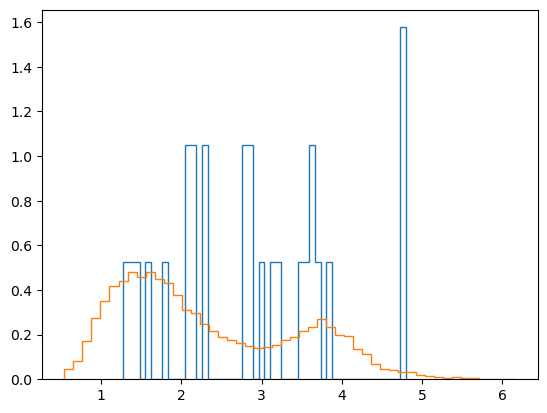

In [13]:
plt.hist(trijet_deltar_bkg,bins=50,histtype='step',density=True)
plt.hist(trijet_deltar_sig,bins=50,histtype='step',density=True)
plt.show()

In [16]:
predicted = model.predict(features_test).astype(bool)
labels_test = np.array(labels_test, dtype=bool)

print("Efficiency = ", 100*sum(predicted*labels_test)/len(predicted), "%")

NameError: name 'model' is not defined

In [15]:
events = NanoEventsFactory.from_root(local_file_name, schemaclass=AGCSchema, treepath="events").events()

NameError: name 'local_file_name' is not defined